MIDA Gondara and Wang(2018) in Python (using PyTorch)
https://arxiv.org/abs/1705.02737
https://gist.github.com/lgondara/18387c5f4d745673e9ca8e23f3d7ebd3 

# 1. Loading Dataset

## 1.1. Load a dataset and introduce missingness

Dataset used: Shuttle Dataset (https://archive.ics.uci.edu/ml/datasets/Statlog+(Shuttle)

### 1.1.1. Load the dataset and store it as dataframe(numeric)

In [1]:
import pandas as pd
import utils

In [2]:
#Test
filename = "data/shuttle/shuttle_trn"
df = utils.get_dataframe_from_csv(filename).iloc[:,:-1]  #remove label

INFO:root:Input filename has to be space separated data


In [3]:
# #Test
# filename = "data/shuttle/shuttle_trn_debug"
# train_df = utils.get_dataframe_from_csv(filename).iloc[:,:-1]  #remove label

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8
0,50,21,77,0,28,0,27,48,22
1,55,0,92,0,0,26,36,92,56
2,53,0,82,0,52,-5,29,30,2
3,37,0,76,0,28,18,40,48,8
4,37,0,79,0,34,-26,43,46,2


### 1.1.2. Inducing missingness

After dataset loading, start with inducing missingness. 

To start off, introduce simple random missing patterns (Missing Completely At Random), i.e. sample half of the variables and set observations in those variables to missing if an appended random uniform vector has value less than a certain threshhold. WIth threshold of 0.2, the procedure should introduce about 20% missingness.

In [5]:
#test
df1 = df[:]
df2 = utils.induce_missingness(df1,logger_level=20)

INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.79


In [6]:
df1.head()

,0,1,2,3,4,5,6,7,8
0,50,21,77,0,28,0,27,48,22
1,55,0,92,0,0,26,36,92,56
2,53,0,82,0,52,-5,29,30,2
3,37,0,76,0,28,18,40,48,8
4,37,0,79,0,34,-26,43,46,2


In [7]:
df2.head()

,0,1,2,3,4,5,6,7,8
0,50,21,77,0,NaN,0,NaN,NaN,NaN
1,55,0,92,0,0.0,26,36.0,92.0,56.0
2,53,0,82,0,52.0,-5,29.0,30.0,2.0
3,37,0,76,0,28.0,18,40.0,48.0,8.0
4,37,0,79,0,34.0,-26,43.0,46.0,2.0


### 1.1.3. Create Train-Test split

Create 70% training data and 30%  test data which includes missingness and a test data without missingness so we can calculate performance. 

In [8]:
#Test
train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df1, test_perc=0.3, logger_level=20)
print(train_df.head())
print(test_df.head())
print(full_test_df.head())

INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.79
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs


        0  1    2  3     4  5     6     7    8
7476   55  0   98  0   NaN -4   NaN   NaN  NaN
31355  50 -5  102  2  50.0  0  52.0  53.0  0.0
38462  37  0   77  0  36.0 -2  40.0  41.0  2.0
20525  55 -2   95  0  46.0 -3  40.0  49.0  8.0
34457  55  0   92  8   NaN  0   NaN   NaN  NaN
        0  1   2  3     4   5     6     7     8
15528  45 -1  76  0   NaN -16   NaN   NaN   NaN
14327  37  0  95  0  10.0   7  58.0  84.0  26.0
12125  37  0  75 -4  30.0   0  38.0  44.0   6.0
39952  55  0  96  0  50.0   4  41.0  47.0   6.0
1339   41 -1  76  0   NaN -14   NaN   NaN   NaN
        0  1   2  3   4   5   6   7   8
15528  45 -1  76  0  44 -16  31  32   2
14327  37  0  95  0  10   7  58  84  26
12125  37  0  75 -4  30   0  38  44   6
39952  55  0  96  0  50   4  41  47   6
1339   41 -1  76  0  38 -14  35  37   2


# 2. Modelling

Proceed to modelling.

In R:
Start with initializing 'h2o' package and then reading the training and test datasets as the 'h2o's supported format.
Then run imputation model multiple times as each new start would initialize the weights with different values.<br>
Info at: <br>
[h2o](https://cran.r-project.org/web/packages/h2o/h2o.pdf) package offers an easy to use function for implementing autoencoders. 
More information is available at this [link](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/DeepLearningBooklet.pdf).

In Python: Using PyTorch to create the DAE, and train using the Adam optimizer from PyTorch

In [9]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.functional as F

In [10]:
#Settings for device, randomization seed, default tensor type, kwargs for memory #DevSeedTensKwargs
RANDOM_SEED = 18
np.random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    kwargs = {'num_workers':4, 'pin_memory' :True}
else:
    device = 'cpu'
    torch.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.FloatTensor)
    kwards = {}

In [11]:
import dataset_module

In [12]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe

In [13]:
len(trainset)

30450

In [14]:
import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()))

In [15]:
net

DenoisingAutoEncoder(
  (drop_layer): Dropout(p=0.5)
  (linear_layer_list): ModuleList(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=23, bias=True)
    (2): Linear(in_features=23, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=23, bias=True)
    (4): Linear(in_features=23, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=9, bias=True)
  )
)

# 3. Training

In [16]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
# testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs) 

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [17]:
'''
TO DO:
:- Nesterov Momentum + Adam- Pytorch? Decay factor?
'''
import os
from tqdm import tqdm_notebook as tqdm
def train_model(start_steps = 0, end_steps = 5, net=None, model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout", logger_level = 20):
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)

    NaN_flag = False
    
    for epoch in tqdm(range(start_steps, end_steps)):
        count = epoch-start_steps+1
        net.train()
        #Epoch begins
        epoch_loss = 0.0
        for x, d in tqdm(train_loader):
            # Normalize between [0,1] for better convergence 
            original_x = x
            x[torch.isnan(x)]=0   #If an entire column is zero, division by 0, replace NaNs with zero
            d[torch.isnan(d)]=0 

            optimizer.zero_grad()
            x = x.to(device)
            with torch.no_grad():
                d = d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y, d))   #RMSE Loss   
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            #Break if NaN encountered
            if torch.isnan(loss) or torch.isinf(loss):
                logging.info(f"Loss value: {loss.item()}")
                logging.info("NaN/inf occured at:")
                logging.info(f"{x}\n")
                logging.info(f"{d}\n")
                logging.info(f"Original x was : {original_x}")
                NaN_flag = True
                break

            logging.debug(f"Count: {count}, Loss :{loss}")
            
        if NaN_flag: break   #Stop training if NaN encountered
            
        #Print to screen every few epochs    
        if count%LOG_INTERVAL == 0:
            print(f"Epoch number:{epoch} Loss: {epoch_loss:.4f}")  
            
        #Training artifacts
        if model_name not in os.listdir():
            os.makedirs(model_name+"/artifacts/saved_model/")

        #Write to loss file every epoch
        with open(model_name+"/artifacts/loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {epoch_loss:.4f}\n")
        
        #Save model every few epochs
        if epoch%SAVE_INTERVAL== 0:
            torch.save(net.state_dict(),f"./{model_name}/artifacts/saved_model/model_at_epoch{epoch}")
        #Epoch Ends

In [18]:
model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout"

In [19]:
train_model(0,501, net, model_name)

Epoch number:9 Loss: 3.2525


Epoch number:19 Loss: 2.9236


Epoch number:29 Loss: 2.6439


Epoch number:39 Loss: 2.4943


Epoch number:49 Loss: 2.4521


Epoch number:59 Loss: 2.3827


Epoch number:69 Loss: 2.2995


Epoch number:79 Loss: 2.1783


Epoch number:89 Loss: 2.1833


Epoch number:99 Loss: 2.1609


Epoch number:109 Loss: 2.1371


Epoch number:119 Loss: 2.1383


Epoch number:129 Loss: 2.1170


Epoch number:139 Loss: 2.1350


Epoch number:149 Loss: 2.1370


Epoch number:159 Loss: 2.1063


Epoch number:169 Loss: 2.1008


Epoch number:179 Loss: 2.0528


Epoch number:189 Loss: 2.0605


Epoch number:199 Loss: 2.0382


Epoch number:209 Loss: 2.0334


Epoch number:219 Loss: 2.0182


Epoch number:229 Loss: 2.0330


Epoch number:239 Loss: 2.0054


Epoch number:249 Loss: 2.0189


Epoch number:259 Loss: 1.9930


Epoch number:269 Loss: 1.9892


Epoch number:279 Loss: 1.9857


Epoch number:289 Loss: 1.9691


Epoch number:299 Loss: 1.9868


Epoch number:309 Loss: 1.9616


Epoch number:319 Loss: 1.9805


Epoch number:329 Loss: 1.9570


Epoch number:339 Loss: 1.9765


Epoch number:349 Loss: 1.9783


Epoch number:359 Loss: 1.9452


Epoch number:369 Loss: 1.9669


Epoch number:379 Loss: 1.9485


Epoch number:389 Loss: 1.9599


Epoch number:399 Loss: 1.9328


Epoch number:409 Loss: 1.9615


Epoch number:419 Loss: 1.9736


Epoch number:429 Loss: 1.9252


Epoch number:439 Loss: 1.9633


Epoch number:449 Loss: 1.9335


Epoch number:459 Loss: 1.9472


Epoch number:469 Loss: 1.9226


Epoch number:479 Loss: 1.9403


Epoch number:489 Loss: 1.9362


Epoch number:499 Loss: 1.9348


In [ ]:
# '''Remove folder before training again'''
# import shutil
# shutil.rmtree(model_name)

Learning Rate annealing:- Maybe need a smaller learning rate after a while? 
Nesterov momentum:- Check paper to see if all the features have been implemented exactly (like Nesterov?)
              
Experiments to try:
1. Plot different values for different architectures.
2. Try feeding in with just the imputed values instead of the whole predicted data.
3. Try without dropout.

Features needed:

1. Printing out the denormalized data in prediction - DONE
2. Store the ids of NaNs before filling them up with placeholders - Not Needed, wrote a better TEST FUNCTION
3. Do 70/30 Split before training, testing - DONE
4. Add provision in model for changing theta params - DONE
5. Add provision for removing dropout - DONE
6. Plotting Loss function - DONE

In [ ]:
# Saving model

#torch.save(optimizer.state_dict(), filename)
#optimizer.load_state_dict(torch.load(filename))

# Modelling Loading from saved point

# model =  Modelling.DenoisingAutoEncoder(len(trainset.variables()))
# model.load_state_dict(torch.load("./artifacts/saved_model_epoch50"))
# model.eval()

In [ ]:
#Tweaking the learning rate to improve convergence speed
# optimizer = Adam(net.parameters(), LR)

# 4. Testing

In [20]:
net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

tensor([0.1331, 0.5037, 0.4169, 0.5051, 0.2491, 0.5361, 0.4428, 0.7354, 0.7056])
tensor([0.2917, 0.5068, 0.6016, 0.5070, 0.3569, 0.5407, 0.5416, 0.6481, 0.5944])


In [21]:
net = net.eval()
print(trainset.get_denormalized_data((net(trainset[0][0].detach()))))
print(trainset.get_denormalized_data(trainset[0][0]))

           0          1          2          3          4           5  \
0  39.778984 -28.952637  74.364319 -14.581299 -32.533188 -121.011719   

           6           7          8  
0  22.533051  105.172821  82.893127  
      0    1     2    3        4    5          6          7          8
0  55.0  0.0  98.0  0.0  34.6819 -4.0  37.159561  50.757996  13.739258


In [22]:
import pandas as pd
import torch
def test_model(net=None, test_df= None, trainset=None, device =None, logger_level=20):
    """
    Function to evaluate the model on test set
    Should meet the following requirements:
        :-trainset - should be an object of class DataSetForImputation
        :-test_df - should be a Pandas dataframe with NaNs (if there are no NaNs, the same will be returned)
        :-net - should be an object of DenoisingAutoEncoder
    """
    assert isinstance(net, Modelling.DenoisingAutoEncoder)
    assert isinstance(test_df, pd.DataFrame)
    assert isinstance(trainset, dataset_module.DataSetForImputation)
    
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)
    
    NaN_test_df = test_df.reset_index(drop=True)  #Dropping index so that everything is reindexed from 0
       
    test_df = test_df.apply(lambda x: x.fillna(x.mean()), axis=0)
    test_df_norm = (test_df- trainset.min_df)/(trainset.max_df-trainset.min_df)
    test_df_tensor = torch.tensor(test_df_norm.values).to(device)
        
    net = net.eval()
    logging.debug(f"{test_df_tensor.shape}")
    pred = net(test_df_tensor)
     
    pred =  trainset.get_denormalized_data(pred)  #Predicted dataframe from the mode    
    
    # Replace the NaNs in the original test_df with newly imputed values
    final_pred = NaN_test_df.where(~NaN_test_df.isna(), other = pred)
    logging.debug(f"final_pred:\n {final_pred.head()}")
    
    return final_pred

In [23]:
test_df.head()

,0,1,2,3,4,5,6,7,8
15528,45,-1,76,0,NaN,-16,NaN,NaN,NaN
14327,37,0,95,0,10.0,7,58.0,84.0,26.0
12125,37,0,75,-4,30.0,0,38.0,44.0,6.0
39952,55,0,96,0,50.0,4,41.0,47.0,6.0
1339,41,-1,76,0,NaN,-14,NaN,NaN,NaN


In [24]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8
0,45,-1,76,0,-47.401643,-16,27.716131,121.845103,94.131345
1,37,0,95,0,10.000000,7,58.000000,84.000000,26.000000
2,37,0,75,-4,30.000000,0,38.000000,44.000000,6.000000
3,55,0,96,0,50.000000,4,41.000000,47.000000,6.000000
4,41,-1,76,0,-48.913076,-14,29.316772,123.623287,94.329691


# 5. Plotting Loss Curve

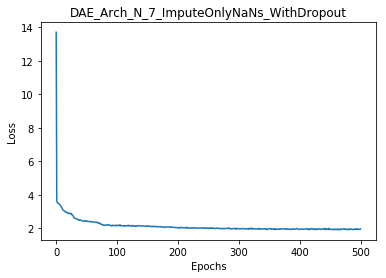

In [26]:
utils.plot_loss_curve(title=f"{model_name}")

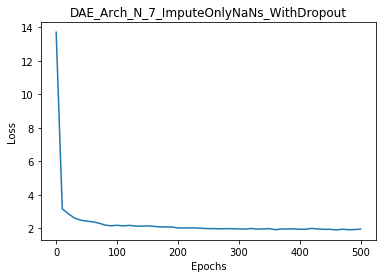

In [27]:
utils.plot_loss_curve(title=f"{model_name}",freq=10)

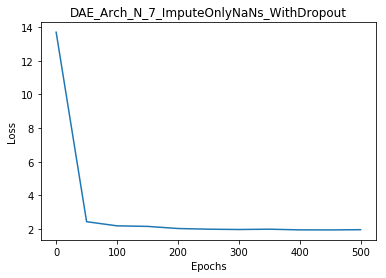

In [28]:
utils.plot_loss_curve(title=f"{model_name}",freq=50)